In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from tensorflow.keras.regularizers import l2

from tensorflow.keras.layers import (Input, Dense, Lambda, Flatten, Reshape, BatchNormalization, 
                          Activation, Dropout, Conv2D, Conv2DTranspose,
                          Concatenate, Add, Multiply)

In [2]:
img_rows, img_cols, img_chns = 28, 28, 1
original_img_size = (img_rows, img_cols, img_chns)
batch_size = 256
# 生成的z的维度
latent_dim = 16

epochs = 1000
learning_rate = 0.0005
dropout = 0.1

# 8000太大了，内存不够，设置成一半
hidden_units = 4000
# masking dense的层数
hidden_layers = 3

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train.astype(np.float32), X_test.astype(np.float32)

X_train = np.round(X_train.reshape(X_train.shape[0], img_rows * img_cols) / 255.)
X_test = np.round(X_test.reshape(X_test.shape[0], img_rows * img_cols) / 255.)

# (60000, 784) 的x_train切片，切成60000份，每个train_data都是 784的大小
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
# repeat() 相当于一个dataset训练两遍，batch是一次取出256个image的数据，prefetch(1)是每次预存一个batch，shuffle指一个pool有多大
train_data = train_data.repeat().batch(batch_size).prefetch(1)

test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
test_data = test_data.repeat().batch(batch_size).prefetch(1)

In [4]:
def draw_all_in_a_batch(x_hat, n=16):
    assert x_hat.shape[0] >= n*n
    canvas_recon = np.empty((28 * n, 28 * n))    
    new_images = x_hat
    
    for i in range(n):
        for j in range(n):
            img = new_images[i*n+j].numpy().reshape([28, 28])
            
            # 两种方式都没有办法达到那种渐变效果，渐变效果是因为他的latent的生成受到了严格的控制，而不是像下面这样都是随机的
            
            canvas_recon[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = img
        
    plt.figure(figsize=(n, n))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()

masking layer

In [5]:
from tensorflow.keras import backend as K
from tensorflow.keras import initializers
from tensorflow.keras import activations
from tensorflow.keras import regularizers
from tensorflow.keras import constraints


class MaskingDense(tf.keras.layers.Layer):
    """ Just copied code from keras Dense layer and added masking and a few other tricks:
        - Direct auto-regressive connections to output
        - Allows a second (non-autoregressive) input that is fully connected to first hidden
        - Either 1 output or 2 outputs (concatenated) that are separately
          auto-regressive wrt to the input
    """

    def __init__(self, units, out_units,
                 hidden_layers=1,
                 dropout_rate=0.0,
                 random_input_order=False,
                 activation='elu',
                 out_activation='sigmoid',
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 out_kernel_initializer='glorot_uniform',
                 out_bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(MaskingDense, self).__init__(**kwargs)

        self.input_sel = None
        self.random_input_order = random_input_order
        self.rate = min(1., max(0., dropout_rate))
        self.kernel_sels = []
        self.units = units
        self.out_units = out_units
        self.hidden_layers = hidden_layers
        self.activation = activations.get(activation)
        self.out_activation = activations.get(activation)
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.out_kernel_initializer = initializers.get(out_kernel_initializer)
        self.out_bias_initializer = initializers.get(out_bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)

    def dropout_wrapper(self, inputs, training):
        if 0. < self.rate < 1.:
            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape=None, seed=None)
            return K.in_train_phase(dropped_inputs, inputs,
                                    training=training)

        return inputs

    def build_layer_weights(self, input_dim, units, use_bias=True, is_output=False):
        kernel_initializer = (self.kernel_initializer if not is_output
                              else self.out_kernel_initializer)
        bias_initializer = (self.bias_initializer if not is_output
                            else self.out_bias_initializer)

        kernel = self.add_weight(shape=(input_dim, units),
                                 initializer=kernel_initializer,
                                 name='kernel',
                                 regularizer=self.kernel_regularizer,
                                 constraint=self.kernel_constraint)

        if use_bias:
            bias = self.add_weight(shape=(units,),
                                   initializer=bias_initializer,
                                   name='bias',
                                   regularizer=self.bias_regularizer,
                                   constraint=self.bias_constraint)
        else:
            bias = None

        return kernel, bias

    def build_mask(self, shape, prev_sel, is_output):
        if is_output:
            if shape[-1] == len(self.input_sel):
                input_sel = self.input_sel
            else:
                input_sel = self.input_sel * 2
        else:
            # Disallow D-1 because it would violate auto-regressive property
            # Disallow unconnected units by sampling min from previous layer
            input_sel = [np.random.randint(np.min(prev_sel), shape[-1] - 2) for i in range(shape[-1])]

        def vals():
            in_len = len(self.input_sel)
            for x in range(shape[-2]):
                for y in range(shape[-1]):
                    if is_output:
                        yield 1 if prev_sel[x] < input_sel[y % in_len] else 0
                    else:
                        yield 1 if prev_sel[x] <= input_sel[y] else 0

        return K.constant(list(vals()), dtype='float32', shape=shape), input_sel

    def build(self, input_shape):
        if isinstance(input_shape, list):
            if len(input_shape) != 2:
                raise ValueError('Only list only supported for exactly two inputs')
            input_shape, other_input_shape = input_shape

            # Build weights for other (non-autoregressive) vector
            other_shape = (other_input_shape[-1], self.units)
            self.other_kernel, self.other_bias = self.build_layer_weights(*other_shape)

        assert len(input_shape) >= 2
        assert self.out_units == input_shape[-1] or self.out_units == 2 * input_shape[-1]

        self.kernels, self.biases = [], []
        self.kernel_masks, self.kernel_sels = [], []
        shape = (input_shape[-1], self.units)

        self.input_sel = np.arange(input_shape[-1])
        if self.random_input_order:
            np.random.shuffle(self.input_sel)
        prev_sel = self.input_sel
        for x in range(self.hidden_layers):
            # Hidden layer
            kernel, bias = self.build_layer_weights(*shape)
            self.kernels.append(kernel)
            self.biases.append(bias)

            # Hidden layer mask
            kernel_mask, kernel_sel = self.build_mask(shape, prev_sel, is_output=False)
            self.kernel_masks.append(kernel_mask)
            self.kernel_sels.append(kernel_sel)

            prev_sel = kernel_sel
            shape = (self.units, self.units)

        # Direct connection between input/output
        if self.hidden_layers > 0:
            direct_shape = (input_shape[-1], self.out_units)
            self.direct_kernel, _ = self.build_layer_weights(*direct_shape, use_bias=False,
                                                             is_output=True)
            self.direct_kernel_mask, self.direct_sel = self.build_mask(direct_shape, self.input_sel,
                                                                       is_output=True)

        # Output layer
        out_shape = (self.units, self.out_units)
        self.out_kernel, self.out_bias = self.build_layer_weights(*out_shape, is_output=True)
        self.out_kernel_mask, self.out_sel = self.build_mask(out_shape, prev_sel, is_output=True)

        self.built = True

    def call(self, inputs, training=None):
        other_input = None
        if isinstance(inputs, list):
            assert len(inputs) == 2
            assert self.hidden_layers > 0, "other input not supported if no hidden layers"
            assert hasattr(self, 'other_kernel')
            inputs, other_input = inputs

        output = inputs

        if other_input is not None:
            other = K.dot(other_input, self.other_kernel)
            other = K.bias_add(other, self.other_bias)
            other = self.activation(other)

        # Hidden layer + mask
        for i in range(self.hidden_layers):
            weight = self.kernels[i] * self.kernel_masks[i]
            output = K.dot(output, weight)

            # "other" input
            if i == 0 and other_input is not None:
                output = output + other

            output = K.bias_add(output, self.biases[i])
            output = self.activation(output)
#             output = self.dropout_wrapper(output, training)

        # out_act(bias + (V dot M_v)h(x) + (A dot M_a)x + (other dot M_other)other)
        output = K.dot(output, self.out_kernel * self.out_kernel_mask)

        # Direct connection
        if self.hidden_layers > 0:
            direct = K.dot(inputs, self.direct_kernel * self.direct_kernel_mask)
            output = output + direct

        output = K.bias_add(output, self.out_bias)
        output = self.out_activation(output)
#         output = self.dropout_wrapper(output, training)

        return output

    def compute_output_shape(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]
        return (input_shape[0], self.out_units)


IAF定义

In [6]:
class MAF(tf.keras.Model):
    def __init__(self, original_size, num_flow=2, latent_dim=16, intermediate_dim=128):
        """
        original_size : 原本的输入size，和输入size相同
        intermediate_dim : 用于原输入到z_0的中间变换尺寸
        latent_dim : 变换后的尺寸
        masking_dim : 用于normalizing flow的条件概率生成的尺寸，一般和latent dim直接相关
        num_flow : flow的数量，严重影响性能，控制在10以内，CAF的建议是7
        """
        super().__init__()
        self.original_size = original_size
        self.latent_dim = latent_dim
        masking_dim = 10 * self.latent_dim
        self.num_flow = num_flow
        
#         self.dense0 = Dense(units=intermediate_dim*2, activation=tf.nn.sigmoid)
        self.dense1 = Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
        self.densez = Dense(units=self.latent_dim)
        self.denselog_sigma = Dense(units=self.latent_dim)
#         self.denseh = Dense(self.latent_dim, activation='sigmoid')
        
        self.maskdense_m = []
        self.maskdense_s = []
        for i in range(self.num_flow):
            self.maskdense_m.append(MaskingDense(masking_dim, self.latent_dim, dropout_rate=0., hidden_layers=2,
                             kernel_regularizer=l2(0.001),
                             bias_regularizer=l2(0.001),
                             activation='sigmoid', out_activation=None))
            self.maskdense_s.append(MaskingDense(masking_dim, self.latent_dim, dropout_rate=0., hidden_layers=2,
                             kernel_regularizer=l2(0.001),
                             bias_regularizer=l2(0.001),
                             activation='sigmoid', out_activation=None))

        self.act = tf.keras.activations.sigmoid
        self.densex1 = tf.keras.layers.Dense(units=intermediate_dim, activation=tf.nn.sigmoid)
#         self.densex2 = tf.keras.layers.Dense(units=intermediate_dim*2, activation=tf.nn.sigmoid)
        self.densex3 = tf.keras.layers.Dense(units=self.original_size, activation=tf.nn.sigmoid)
        
    @tf.function
    def inference(self, inputs): # inference 阶段是x->z_0->z_k。得到了p(Z|X)和p(Z)，density estimation，可以计算KL了
#         x = self.dense0(inputs)
        x = self.dense1(inputs)

        # 初始的z_0
        _z_mean_0 = self.densez(x)
        _z_log_sigma_0 = self.denselog_sigma(x)
        e_0 = tf.keras.backend.random_normal(tf.shape(_z_log_sigma_0), dtype=tf.float32, mean=0., stddev=1.0)
        z_0 = _z_mean_0 + tf.math.exp(_z_log_sigma_0) * e_0

#         h = self.denseh(x)
        z_k = z_0
    
        _z_sigmas = []
        
        for i in range(self.num_flow):
            prev_z = z_k
            m = self.maskdense_m[i](prev_z)
            s = self.maskdense_s[i](prev_z)
            
            # 这里的sigma处理和IAF不同。这里的s是log sigma。因为log后，可以有正有负，容易训练。
            sigma = tf.math.exp(s)
            z_k = (prev_z - m) / sigma  # MAF eq 4
            _z_sigmas.append(sigma)   # MAF eq 5
        
        return z_k, _z_sigmas, e_0, _z_log_sigma_0, _z_sigmas
    
    @tf.function
    def generation(self, z_k): # z_k->x_hat。generation也是生成阶段P(X|Z)。sample
        # z_k 的shape和上面的forward shape保持一致，batch_size * latent_dim
        
        # todo，每个z_k 还原到k-1的第一个的参数，用超参还是生成？如果用0，1的话，就是说每层的第一个，始终都是不变的
        _z_mean_0 = tf.fill(tf.shape(z_k), 0.)
        _z_sigma_0 = tf.fill(tf.shape(z_k), 1.)

        _z_sigmas = []
        # todo 一个参数参与了两个阶段，那么他的梯度是怎样的？
        for i in range(self.num_flow):     # 生成参数的flows顺序反过来
            prev_z = z_k
            for dim in range(self.latent_dim):    # 依赖关系要搞好，generation是迭代的，每次生成dim维的全部batch个z
                if dim == 0:
                    # tensor不支持对tensor slice进行更新。
#                     z_k[:, 0] = _z_mean_0[:, 0] + prev_z[:, 0] * _z_sigma_0[:, 0]
                    z_k_dim = _z_mean_0[:, 0] + prev_z[:, 0] * _z_sigma_0[:, 0]
                    z_k = tf.transpose(tf.tensor_scatter_nd_update(tf.transpose(z_k), [[dim]], [z_k_dim]))
                    continue
                m = self.maskdense_m[self.num_flow - i - 1](z_k)
                s = self.maskdense_s[self.num_flow - i - 1](z_k)
                
                sigma = tf.math.exp(s)
#                 z_k[:, dim] = m[:, dim] + prev_z[:, dim] * sigma[:, dim]
                z_k_dim = m[:, dim] + prev_z[:, dim] * sigma[:, dim]
                z_k = tf.transpose(tf.tensor_scatter_nd_update(tf.transpose(z_k), [[dim]], [z_k_dim]))
            
            # 最后一趟的sigma是保存了全部sigma的数据的
            _z_sigmas.append(sigma)
            
        z_0 = z_k
        
        # 恢复到784大小
        x_hat = self.densex1(z_0)
#         x_hat = self.densex2(x_hat)
        x_hat = self.densex3(x_hat)
    
        return x_hat, _z_sigmas
    
    @tf.function
    def iaf_loss(self, x, x_decoded, e_0, _z_log_sigma_0, _z_sigmas, z):
        # 这里的z是最终变换的z
        logpz = -K.sum(0.5 * np.log(2*math.pi) + 0.5 * z ** 2, axis=-1)
        
        # 因为det很容易计算，所以不用传统vae的kl散度
        det = _z_log_sigma_0
        for z_sigma in _z_sigmas:
            det += K.log(z_sigma)
#             det += K.log(z_sigma)
        logqz_x = -K.sum(0.5 * np.log(2*math.pi) + 0.5 * e_0 ** 2 + det, axis=-1)
        
        # 基本上就是交叉熵？todo为什么要乘大小
        x = K.flatten(x)
        x_decoded = K.flatten(x_decoded)
        xent_loss = self.original_size * tf.keras.metrics.binary_crossentropy(x, x_decoded)
        logpx_z = -xent_loss
        
        # ELBO: - [logp(x|z) + logp(z) - logq(z|x)] = -logp(x|z) - logp(z) + logq(z|x) 实际上他们的ELBO没有区别
        return K.mean(-logpx_z - logpz + logqz_x, axis=-1)
    
    def train_flow_example(self, dataset:tf.data.Dataset, optimizer, training_steps=1000, display_step=100):
        for step, (inputs, _y) in enumerate(dataset.take(training_steps + 1)):
            with tf.GradientTape() as g:
                z_k, _z_sigmas, e_0, _z_log_sigma_0, _z_sigmas = self.inference(inputs)
                x_hat, _z_sigmas_2 = self.generation(z_k)
                loss = self.flow_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)

            if step % display_step == 0:
                print("step: %i, loss: %f" % (step, loss))
            gradients = g.gradient(loss, self.variables)
            optimizer.apply_gradients(grads_and_vars=zip(gradients, self.variables))

In [6]:
maf = MAF(28*28)
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [13]:
x_axis = np.linspace(-1, 1, 255)
ep = np.random.normal(0, 1, size=(1, latent_dim))
for i in x_axis:
    ep = np.append(ep, np.random.normal(i, 1, size=(1, latent_dim)), axis=0)

step: 0, loss: 534.437195
step: 1000, loss: 131.538330
step: 2000, loss: 127.953278


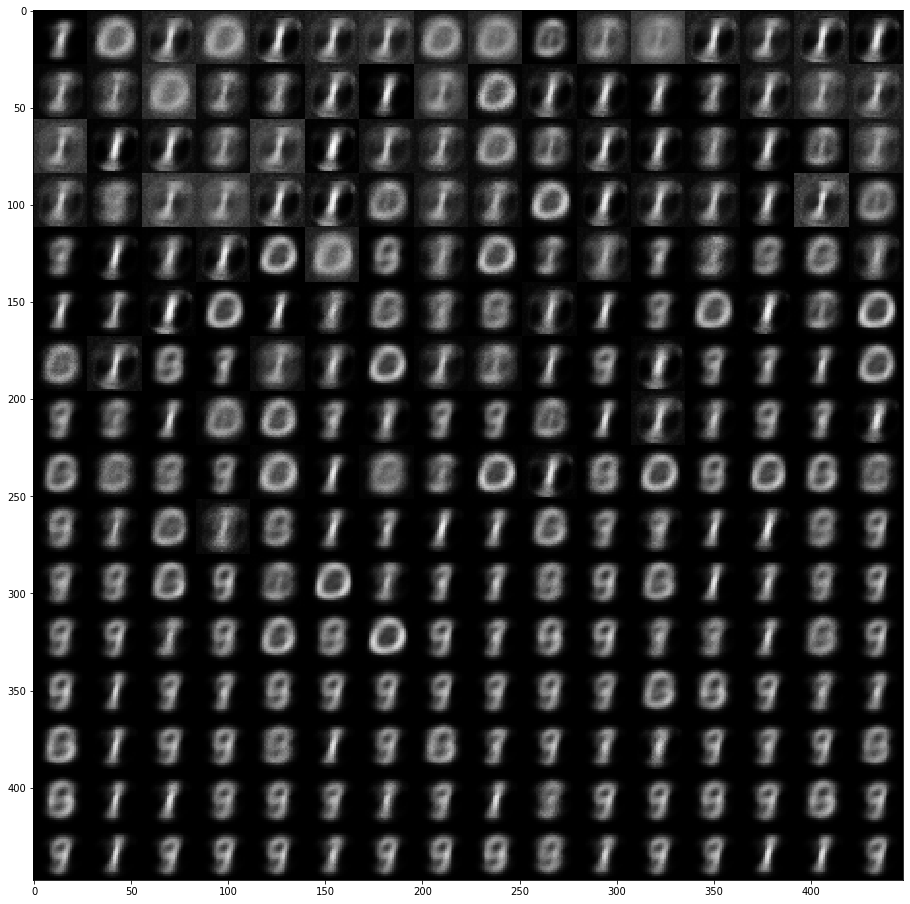

In [14]:
# maf的训练
training_steps = 2000
display_step = 1000

for step, (inputs, _) in enumerate(train_data.take(training_steps + 1)):
    with tf.GradientTape() as g:
        z_k, _z_sigmas, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
        
        x_hat, _z_sigmas_2 = maf.generation(z_k)
        
        loss = maf.iaf_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)

        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
            
    gradients = g.gradient(loss, maf.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, maf.variables))

x_hat, _z_sigmas_2 = maf.generation(tf.cast(tf.convert_to_tensor(ep), dtype='float32'))
draw_all_in_a_batch(x_hat, n=16)

step: 0, loss: 122.959793
step: 1000, loss: 100.713989
step: 2000, loss: 87.440254
step: 3000, loss: 80.568275
step: 4000, loss: 69.204926


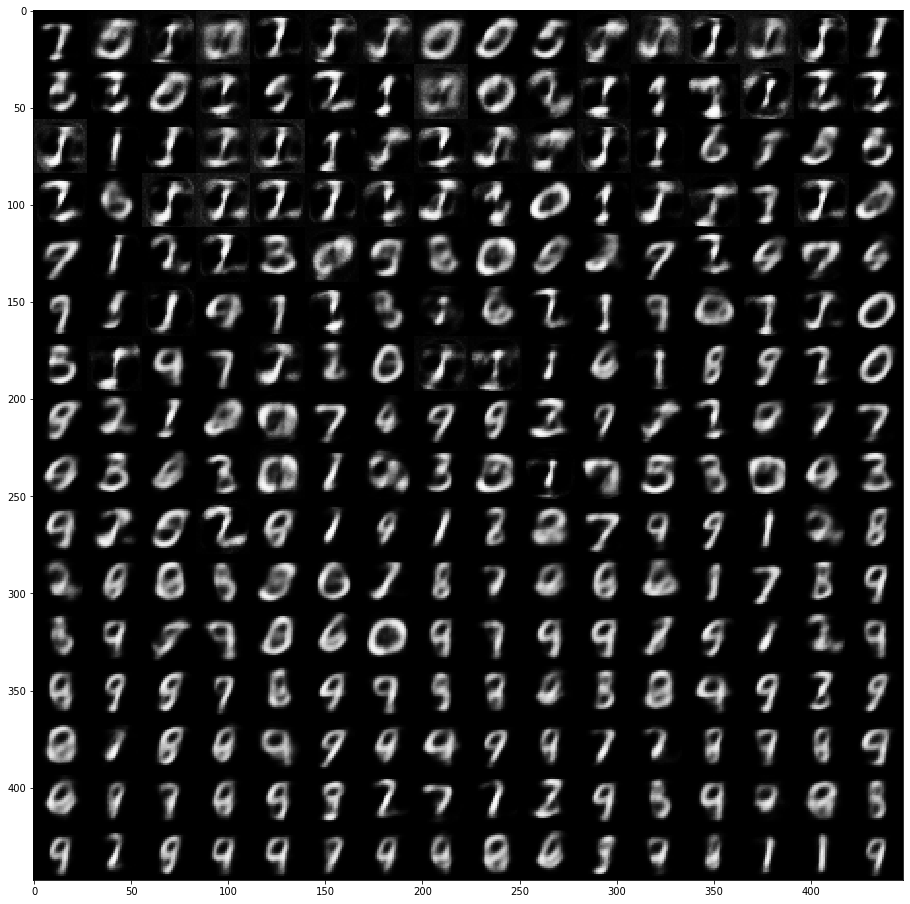

In [16]:
training_steps = 4000
display_step = 1000

for step, (inputs, _) in enumerate(train_data.take(training_steps + 1)):
    with tf.GradientTape() as g:
        z_k, _z_sigmas, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
        
        x_hat, _z_sigmas_2 = maf.generation(z_k)
        
        loss = maf.iaf_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)

        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
            
    gradients = g.gradient(loss, maf.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, maf.variables))

x_hat, _z_sigmas_2 = maf.generation(tf.cast(tf.convert_to_tensor(ep), dtype='float32'))
draw_all_in_a_batch(x_hat, n=16)

step: 0, loss: 67.562973
step: 1000, loss: 66.768723
step: 2000, loss: 65.444534
step: 3000, loss: 65.455902
step: 4000, loss: 58.979698


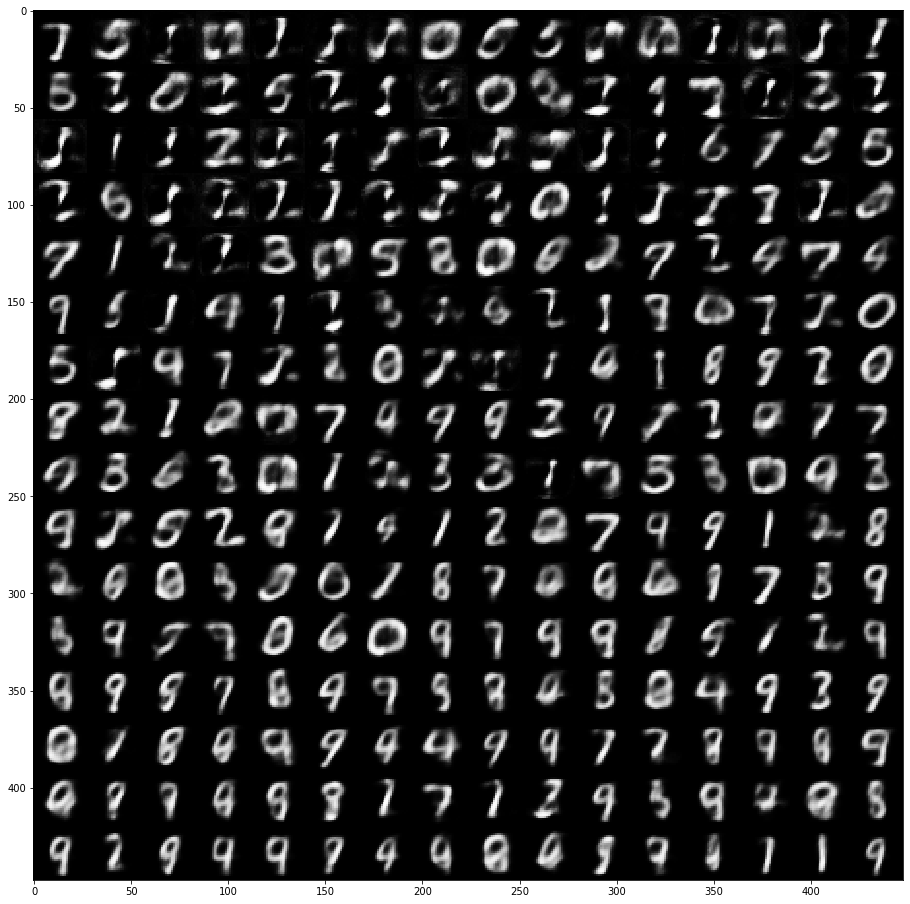

In [17]:
training_steps = 4000
display_step = 1000

for step, (inputs, _) in enumerate(train_data.take(training_steps + 1)):
    with tf.GradientTape() as g:
        z_k, _z_sigmas, e_0, _z_log_sigma_0, _z_sigmas = maf.inference(inputs)
        
        x_hat, _z_sigmas_2 = maf.generation(z_k)
        
        loss = maf.iaf_loss(inputs, x_hat, e_0, _z_log_sigma_0, _z_sigmas, z_k)

        if step % display_step == 0:
            print("step: %i, loss: %f" % (step, loss))
            
    gradients = g.gradient(loss, maf.variables)
    optimizer.apply_gradients(grads_and_vars=zip(gradients, maf.variables))

x_hat, _z_sigmas_2 = maf.generation(tf.cast(tf.convert_to_tensor(ep), dtype='float32'))
draw_all_in_a_batch(x_hat, n=16)

In [18]:
tf.saved_model.save(maf, "./models/maf/10000step/")

W0503 23:27:25.903989 17232 save_impl.py:83] Skipping full serialization of Keras model <__main__.MAF object at 0x000002878AA35940>, because its inputs are not defined.
W0503 23:27:27.662804 17232 deprecation.py:506] From d:\Users\i9233\Anaconda3\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [19]:
maf_reload = tf.saved_model.load("./models/maf/10000step/")

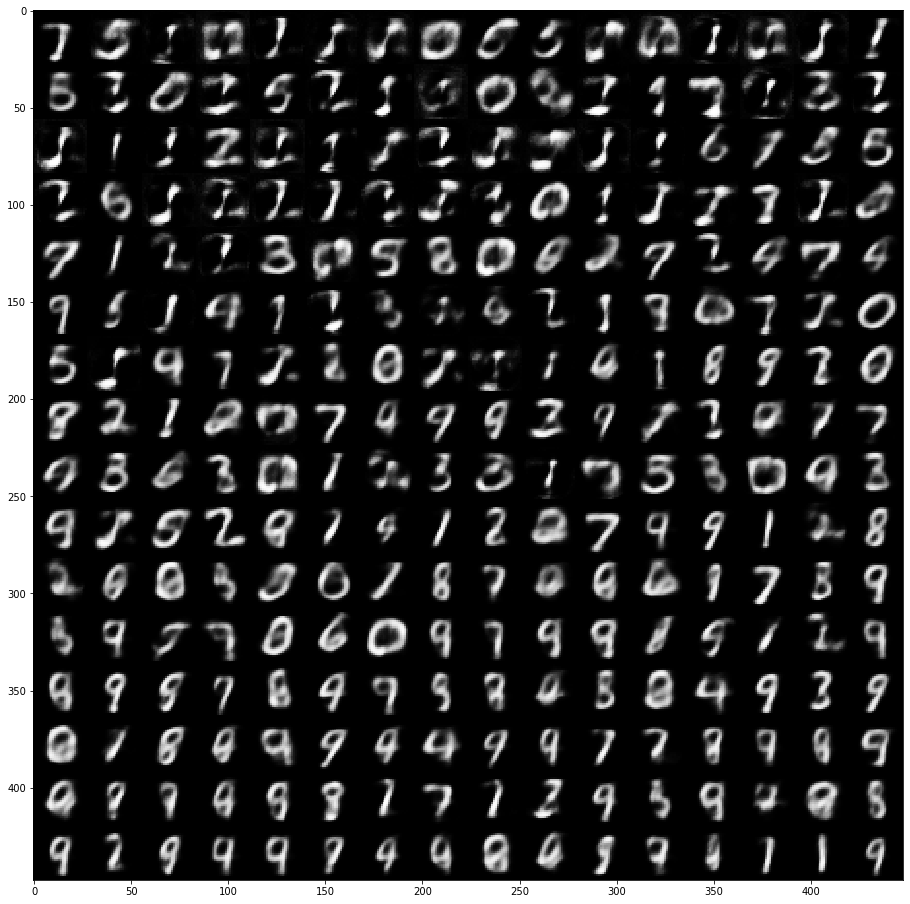

In [20]:
x_hat, _z_sigmas_2 = maf_reload.generation(tf.cast(tf.convert_to_tensor(ep), dtype='float32'))
draw_all_in_a_batch(x_hat)

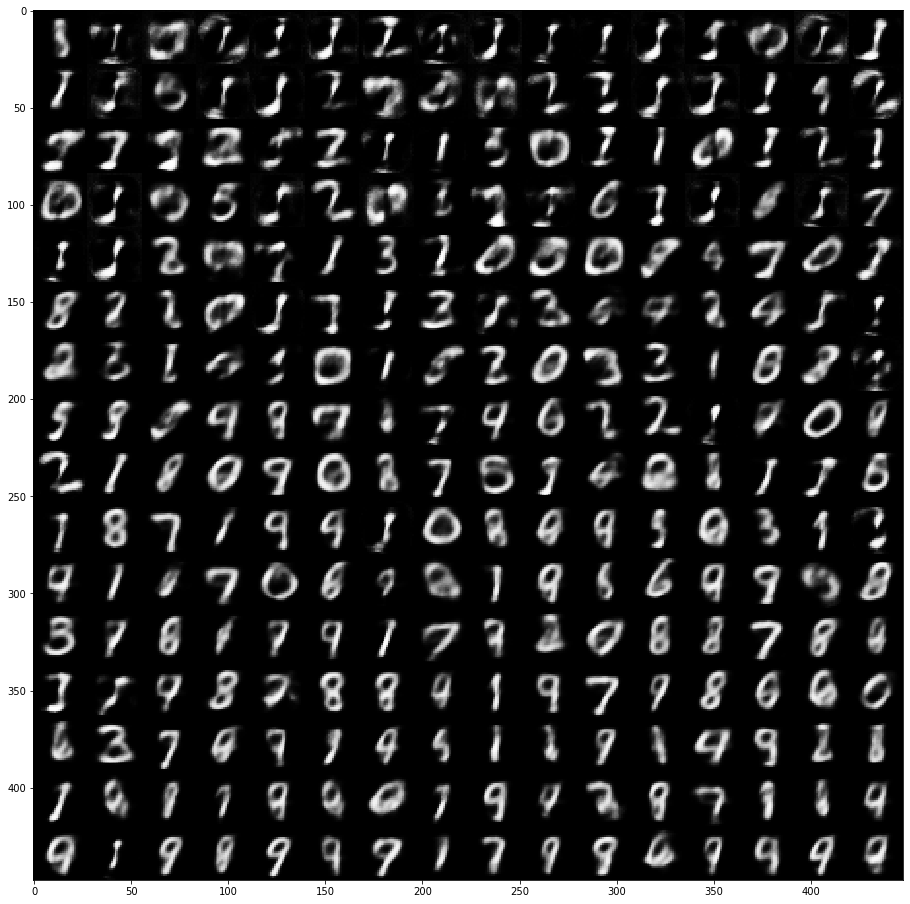

In [21]:
# 先生成255个从 -1 到 1 的递增序列，再按照这个序列作为均值，生成num_latent个latent，就生成了一个新的Z。
x_axis = np.linspace(-1, 1, 255)
ep = np.random.normal(0, 1, size=(1, latent_dim))
for i in x_axis:
    ep = np.append(ep, np.random.normal(i, 1, size=(1, latent_dim)), axis=0)
    
# 如果batch太小了，那么n也需要缩小，n^2 <= batch_size
x_hat, _z_sigmas_2 = maf_reload.generation(tf.cast(tf.convert_to_tensor(ep), dtype='float32'))
draw_all_in_a_batch(x_hat)

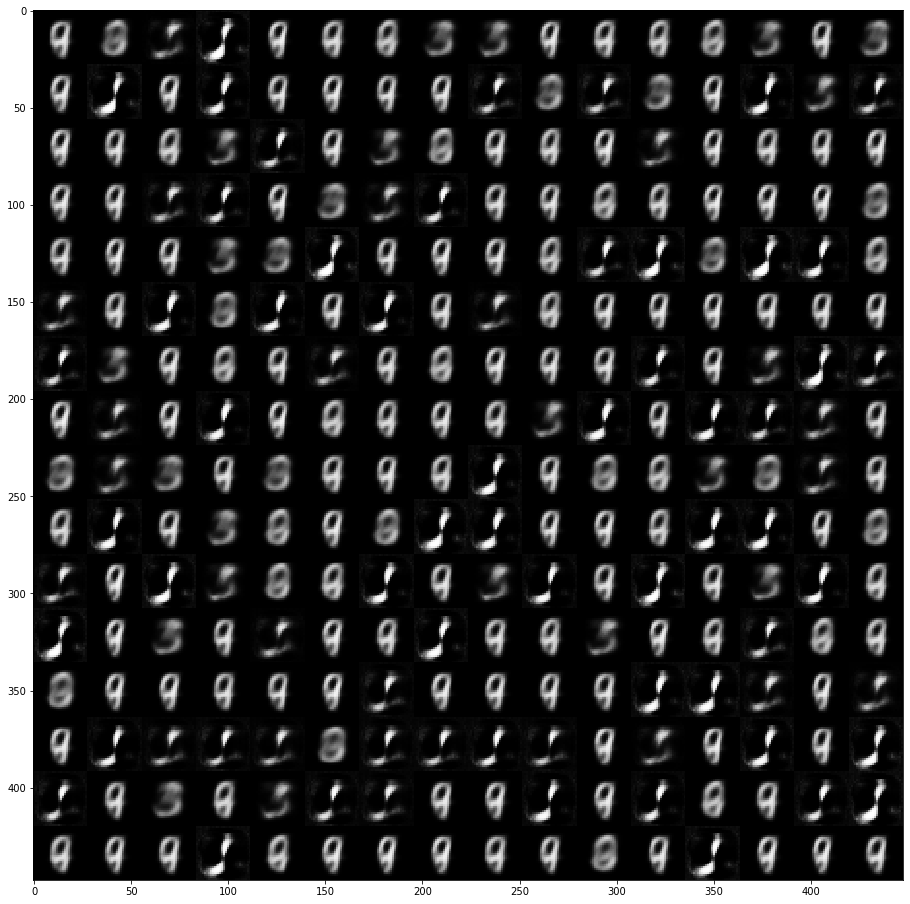

In [22]:
# latent是256个服从标准分布的Z，其中各分量都相同
ep = tf.keras.backend.random_normal([256, 1], dtype=tf.float32, mean=0., stddev=1.0)
latent = tf.repeat(ep, tf.fill([1], 16), axis=1)

x_hat, _z_sigmas_2 = maf_reload.generation(latent)
draw_all_in_a_batch(x_hat)

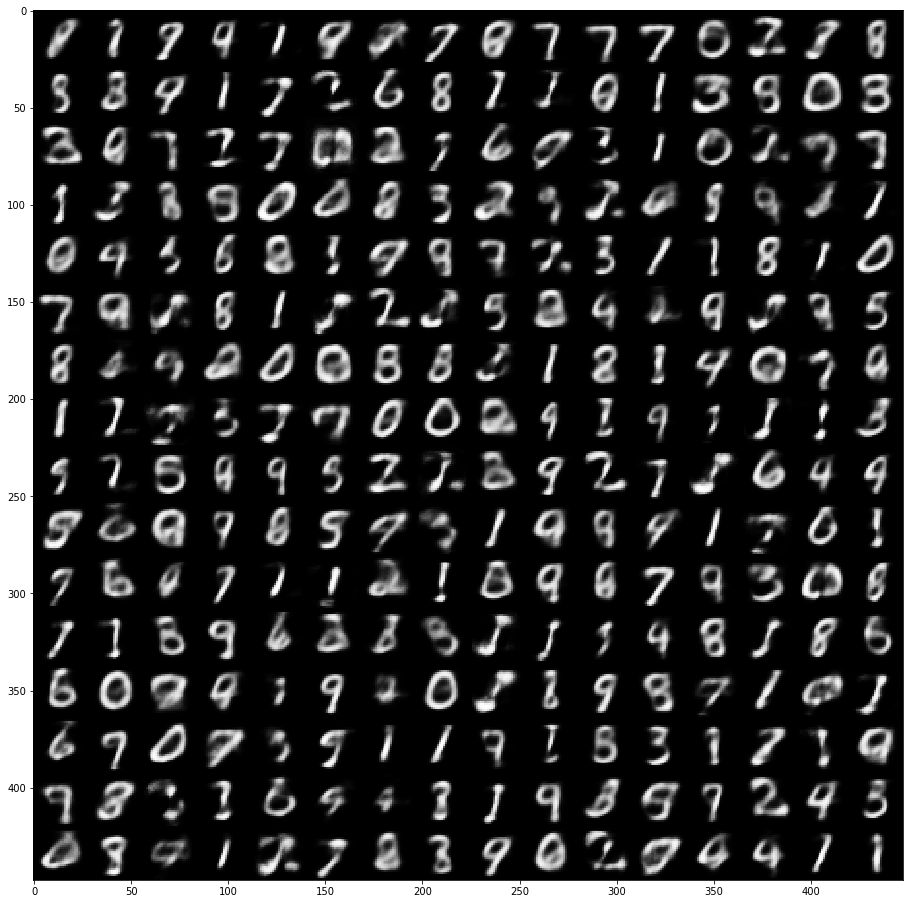

In [23]:
# 从标准正态分布中生成
num_latent = latent_dim
latent = tf.keras.backend.random_normal(shape=(256, num_latent), mean=0.0, stddev=1.0, dtype=None, seed=None)
x_hat, _z_sigmas_2 = maf_reload.generation(latent)
draw_all_in_a_batch(x_hat)

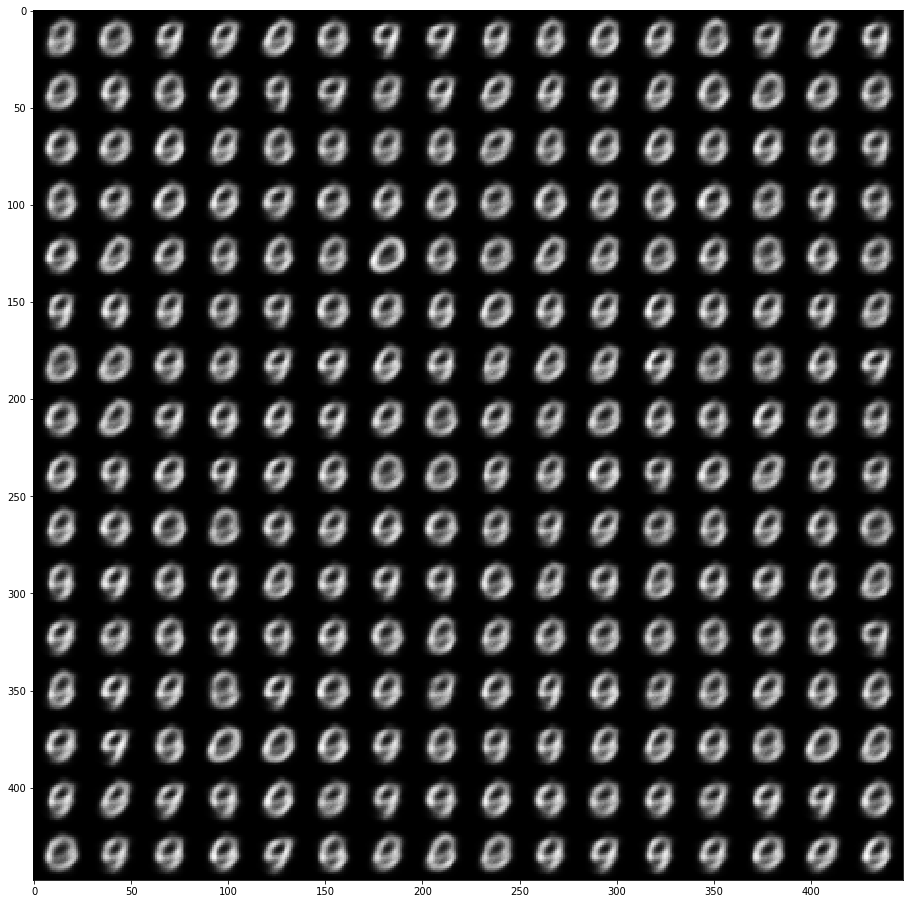

In [21]:
# 均匀分布
x_hat, _z_sigmas_2 = maf_reload.generation(tf.keras.backend.random_uniform(shape=(256, num_latent), dtype=None, seed=None))
draw_all_in_a_batch(x_hat)